### Load Modules

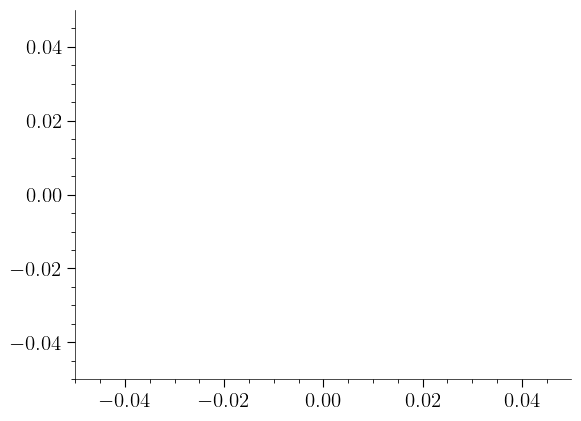

In [1]:
# Restart the kernel
import os
import dill as pickle
current_dir ='../../../'
os.chdir(current_dir)

from src.codes.basic import *
from src.codes.utils.fem_utils import *
from src.codes.utils.plot_utils import ThreeDPlot as plot
from src.codes.utils.plot_utils import data_stats
from src.codes.utils.rom_utils import *

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM, probdata, ROM_simulation
import src.codes.reductor.rom_class as rom_class
from src.codes.algorithms.ecsw import ecsw_red
from importlib import reload
# reload(deim_module)

### Load data

In [2]:
filename_dataC = 'examples/heat_conduction/ThreeD_heat_conduction/data/DataClass_3.dill'
with open(filename_dataC, 'rb') as f:
    Data_cls = pickle.load(f)

# load required variables from data
FOS = Data_cls.FOS
d = FOS.data
param_list = np.asarray(Data_cls.param_list)
NLS = np.asarray(Data_cls.NL_solutions)
K_mus = Data_cls.K_mus
q_mus = Data_cls.q_mus
eval_rom = False

N_snap,_ = np.shape(NLS)
print(N_snap)

100


### Plot data

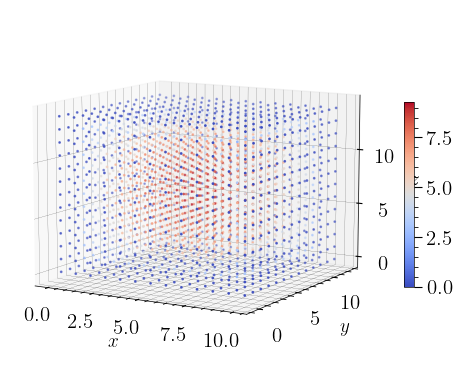

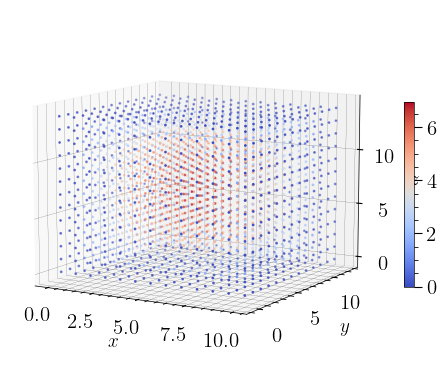

In [3]:
for i in range(2):
    Plot = plot(d.xi[0], d.xi[1], d.xi[2], NLS[i])
    Plot.plot3D()
plt.show()

## ECSW Hyper-reduction

### Train-Test split

In [4]:
train_mask, test_mask = train_test_split(N_snap)

NLS_train = NLS[train_mask]
param_list_train = param_list[train_mask]

NLS_test = NLS[test_mask]


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

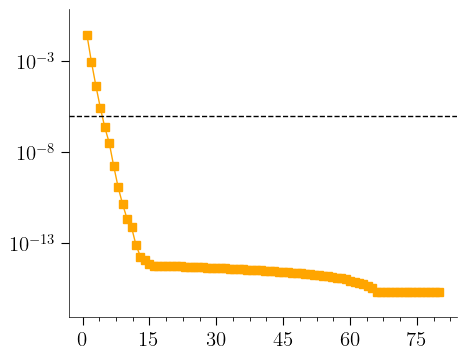

Number of modes selected: 5


In [5]:
n_sel, U = svd_mode_selector(NLS_train, tolerance=1e-6,modes=True)
V_sel = U[:, :n_sel]

In [6]:
# for i in range(n_sel):
#     plot(d.xi[0], d.xi[1], V_sel[:,i],elev=15, azim=60).surface_()

### Step 2: Perform NNLS for ECSW

In [1]:
tic_h_setup_b = time.time()

N_snap_train,_ = np.shape(NLS_train)
tol = 1.0
xi, residual = ecsw_red(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap_train, d.mask, NLS_train,tol=tol)

toc_h_setup_b = time.time()

NameError: name 'time' is not defined

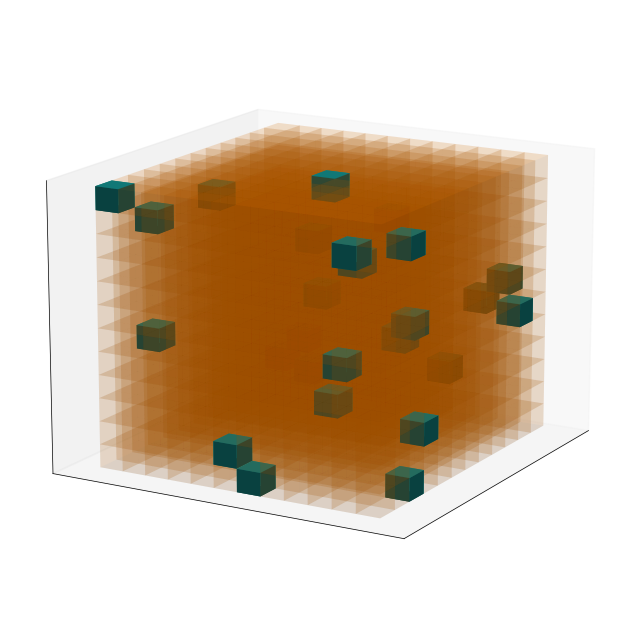

Fraction of total elements active in the ROM: 1.5046296296296295%
residual: 2.6408504401269665e-05


In [18]:
plot(0,0,0,0).element3D((d.ncells[0],d.ncells[1],d.ncells[2]), xi, FOS)
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")
print(f"residual: {residual}")


### ROM Simulation

In [19]:
ROM_h = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel, xi)#, N_rom_snap=1)
ROM_h.run_simulation_h_ecsw()

c:\Users\suparnob\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [20]:
if eval_rom:
    ROM = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel, xi, N_rom_snap=10)
    ROM.run_simulation()

### Performance Statistics

In [21]:
NLS_rom_h = np.asarray(ROM_h.NL_solutions_rom)
ROM_speed_up_h = ROM_h.speed_up_h
ROM_relative_error_h = ROM_h.rom_error

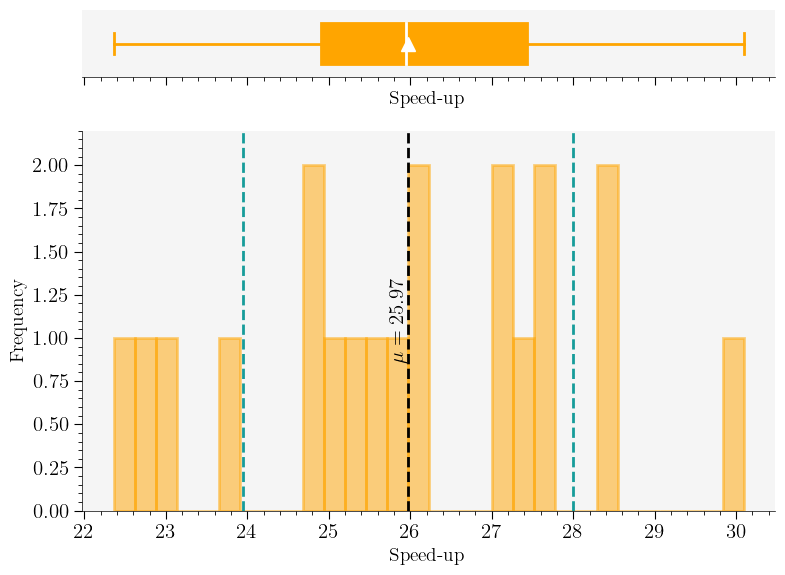

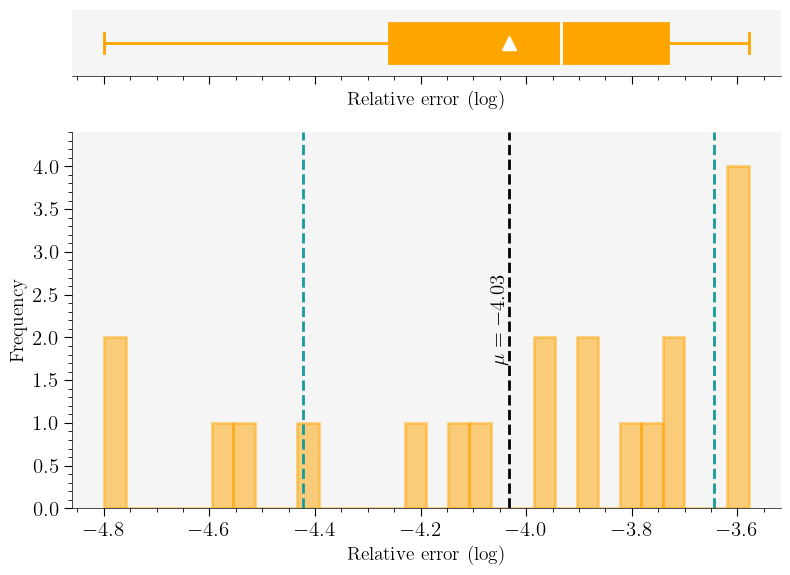

In [22]:
data_stats(ROM_speed_up_h, show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Speed-up", ylabel="Frequency");
data_stats(np.log10(ROM_relative_error_h), show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Relative error (log)", ylabel="Frequency");

In [23]:
if eval_rom:
    NLS_rom = np.asarray(ROM.NL_solutions_rom)
    ROM_speed_up = ROM.speed_up
    ROM_relative_error = ROM.rom_error

In [24]:
if eval_rom:
    data_stats(ROM_speed_up, show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Speed-up", ylabel="Frequency");
    data_stats(np.log10(ROM_relative_error), show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Relative error (log)", ylabel="Frequency");